
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/34_Regularization_Lasso_Ridge.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 🛡️ Regularyzacja: Lasso, Ridge i ElasticNet (Bat na Overfitting)

W Regresji Liniowej model szuka wag ($w$), które minimalizują błąd:
$$ Loss = (y - \hat{y})^2 $$

Problem: Model może ustawić wagi na kosmiczne wartości (np. $w = 1000000$), żeby idealnie dopasować się do szumu w danych treningowych.

**Rozwiązanie:** Dodajemy karę (Penalty) za wielkość wag.

1.  **Ridge (L2):** Kara za **kwadrat** wag ($w^2$).
    *   Efekt: Wagi robią się malutkie (bliskie zera), ale nigdy nie znikają całkowicie. Dobre, gdy wszystkie cechy są trochę ważne.
2.  **Lasso (L1):** Kara za **wartość bezwzględną** wag ($|w|$).
    *   Efekt: Wagi słabych cech są zerowane **do zera**.
    *   **Magia:** Lasso automatycznie wyrzuca śmieciowe kolumny!
3.  **ElasticNet:** Miesza oba podejścia.

Stworzymy zbiór danych, który ma **więcej kolumn niż wierszy** (koszmar statystyka), żeby wymusić Overfitting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error

# 1. TWORZYMY TRUDNE DANE (Mało wierszy, dużo kolumn)
np.random.seed(42)
n_samples = 50
n_features = 100 # Więcej cech niż próbek! Model zwariuje.

# Tylko 10 pierwszych cech ma sens. Reszta (90) to szum.
X = np.random.randn(n_samples, n_features)

# Prawdziwy wzór: y zależy tylko od pierwszych 10 kolumn
true_weights = np.zeros(n_features)
true_weights[:10] = 1.5 # Prawdziwe wagi to 1.5
y = np.dot(X, true_weights) + np.random.normal(0, 0.5, n_samples) # Dodajemy trochę szumu

# Podział
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Dane: {X.shape}. Mamy 100 kolumn, a tylko 50 wierszy.")
print("To klasyczny przepis na Overfitting.")

Dane: (50, 100). Mamy 100 kolumn, a tylko 50 wierszy.
To klasyczny przepis na Overfitting.


## 1. Linear Regression (Bez hamulców)

Zobaczmy, co zrobi zwykła regresja. Prawdopodobnie oszaleje i zacznie przypisywać ogromne wagi do losowych kolumn szumu.

--- LINEAR REGRESSION ---
Błąd Treningowy: 0.0000 (Podejrzanie mały!)
Błąd Testowy:    9.5339 (Ogromny! Overfitting!)


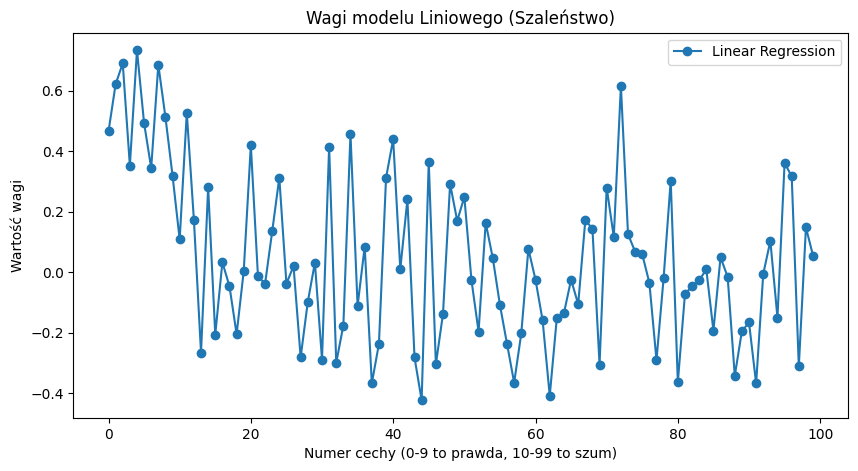

Wniosek: Spójrz na wykres. Wagi latają od -10 do 10, nawet dla cech-śmieci (powyżej indeksu 10).


In [2]:
# Trenujemy zwykłą regresję
lr = LinearRegression()
lr.fit(X_train, y_train)

# Sprawdzamy błędy
train_err = mean_squared_error(y_train, lr.predict(X_train))
test_err = mean_squared_error(y_test, lr.predict(X_test))

print("--- LINEAR REGRESSION ---")
print(f"Błąd Treningowy: {train_err:.4f} (Podejrzanie mały!)")
print(f"Błąd Testowy:    {test_err:.4f} (Ogromny! Overfitting!)")

# Wykres wag
plt.figure(figsize=(10, 5))
plt.plot(lr.coef_, marker='o', label='Linear Regression')
plt.title("Wagi modelu Liniowego (Szaleństwo)")
plt.xlabel("Numer cechy (0-9 to prawda, 10-99 to szum)")
plt.ylabel("Wartość wagi")
plt.legend()
plt.show()

print("Wniosek: Spójrz na wykres. Wagi latają od -10 do 10, nawet dla cech-śmieci (powyżej indeksu 10).")

## 2. Ridge (L2) - Uspokajacz

Dodajemy parametr `alpha` (siła kary).
Ridge zmniejszy wagi, ale ich nie wyzeruje. Wykres powinien być bardziej "płaski".

--- RIDGE (L2) ---
Błąd Treningowy: 0.0027
Błąd Testowy:    9.5418


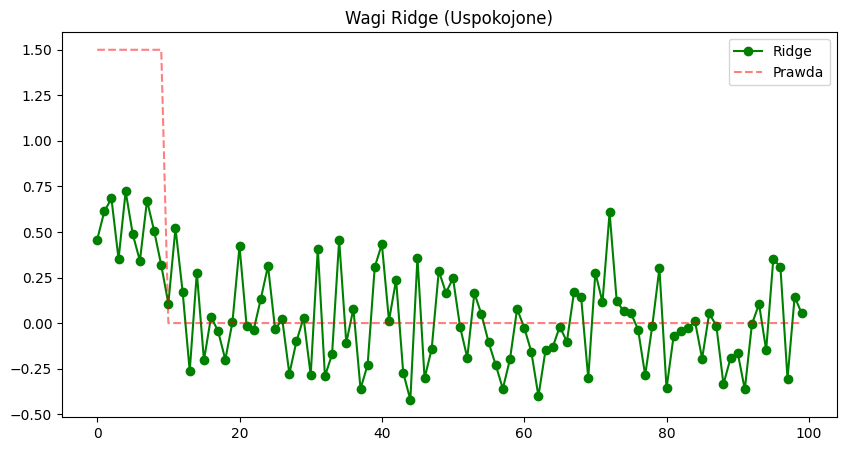

Wniosek: Wagi są mniejsze, bliżej zera, ale nadal szumią.


In [3]:
# Trenujemy Ridge (alpha=1.0)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

print("--- RIDGE (L2) ---")
print(f"Błąd Treningowy: {mean_squared_error(y_train, ridge.predict(X_train)):.4f}")
print(f"Błąd Testowy:    {mean_squared_error(y_test, ridge.predict(X_test)):.4f}")

plt.figure(figsize=(10, 5))
plt.plot(ridge.coef_, color='green', marker='o', label='Ridge')
# Rysujemy prawdziwe wagi (ideał) dla porównania
plt.plot(true_weights, 'r--', label='Prawda', alpha=0.5)
plt.title("Wagi Ridge (Uspokojone)")
plt.legend()
plt.show()

print("Wniosek: Wagi są mniejsze, bliżej zera, ale nadal szumią.")

## 3. Lasso (L1) - Snajper

Lasso ma unikalną cechę matematyczną: jego kształt "pola kary" (romb) sprawia, że rozwiązanie często ląduje idealnie na osiach układu współrzędnych.
W języku ludzi: **Lasso zeruje niepotrzebne wagi.**

--- LASSO (L1) ---
Błąd Treningowy: 0.1911
Błąd Testowy:    1.6192

Lasso wyzerowało 76 z 100 cech!


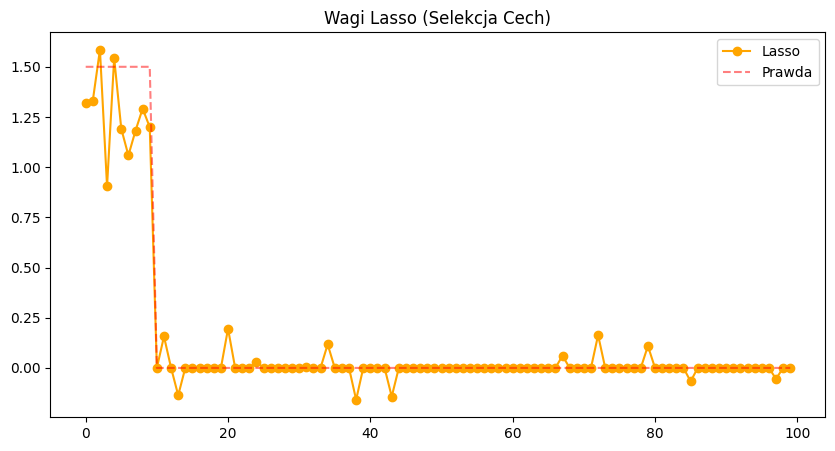

In [4]:
# Trenujemy Lasso (alpha=0.1)
# Uwaga: Lasso wymaga trochę czasu na zbieżność, czasem trzeba zwiększyć max_iter
lasso = Lasso(alpha=0.1, max_iter=2000)
lasso.fit(X_train, y_train)

print("--- LASSO (L1) ---")
print(f"Błąd Treningowy: {mean_squared_error(y_train, lasso.predict(X_train)):.4f}")
print(f"Błąd Testowy:    {mean_squared_error(y_test, lasso.predict(X_test)):.4f}")

# Ile cech zostało wyzerowanych?
zeros = np.sum(lasso.coef_ == 0)
print(f"\nLasso wyzerowało {zeros} z {n_features} cech!")

plt.figure(figsize=(10, 5))
plt.plot(lasso.coef_, color='orange', marker='o', label='Lasso')
plt.plot(true_weights, 'r--', label='Prawda', alpha=0.5)
plt.title("Wagi Lasso (Selekcja Cech)")
plt.legend()
plt.show()

## 🧠 Podsumowanie: L1 czy L2?

Spójrz na ostatni wykres.
*   **Linear:** Chaos.
*   **Ridge:** Uspokojony chaos.
*   **Lasso:** Prawie idealnie odtworzyło "Prawdę"! (Pierwsze 10 wag wysokich, reszta płasko na zerze).

**Kiedy czego używać?**

1.  **Ridge (L2):**
    *   To domyślny wybór w większości przypadków.
    *   Kiedy masz **współliniowość** (np. cechy "Wzrost w cm" i "Wzrost w stopach"). Ridge rozdzieli wagę po równo między nie, co stabilizuje model.
    *   Lasso w takiej sytuacji losowo wybierze jedną, a drugą wyzeruje (co może być ryzykowne).

2.  **Lasso (L1):**
    *   Kiedy podejrzewasz, że **większość Twoich kolumn to śmieci**.
    *   Chcesz dostać prosty, czytelny model (Sparse Model).

3.  **ElasticNet:**
    *   Kiedy nie wiesz co wybrać. Ma dwa suwaki (jeden od L1, drugi od L2). Jest najbezpieczniejszy.

**Tu jest haczyk.**
W sieciach neuronowych (Deep Learning) domyślnie używa się **L2** (nazywa się to tam *Weight Decay*).